In [1]:
# REF: https://machinelearningmastery.com/building-a-plain-seq2seq-model-for-language-translation/
# https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [1]:
import os
import requests
import unicodedata 
import zipfile 
import os
import tokenizers
import numpy as np
import random
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader




In [2]:
# verificar GPU
torch.cuda.is_available()

True

In [3]:
def normalize(line):
    line = unicodedata.normalize("NFKC", line.strip().lower())
    eng, spa = line.split("\t")[:2]
    return eng.lower().strip(), spa.lower().strip()

text_pairs = []
with zipfile.ZipFile("spa-eng.zip", "r") as zip_ref:
    for k, line in enumerate(zip_ref.read("spa.txt").decode("utf-8").splitlines(),start=1):
        #print(line, end="\r")
        eng, spa = normalize(line)
        text_pairs.append((eng, spa))
    print(f"Loaded {k} sentences.")

en_tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE())
es_tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE())
# config tokenizer
en_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.ByteLevel(add_prefix_space=True)
es_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.ByteLevel(add_prefix_space=True)

# config decoder
en_tokenizer.decoder = tokenizers.decoders.ByteLevel()
es_tokenizer.decoder = tokenizers.decoders.ByteLevel()

# train BPE foen eng spa 
#VOCAB_SIZE = 8000
VOCAB_SIZE = 8000
trainer = tokenizers.trainers.BpeTrainer(vocab_size=VOCAB_SIZE,  special_tokens=["[start]", "[end]", "[pad]"],
                                        show_progress=True)
en_tokenizer.train_from_iterator([x[0] for x in text_pairs], trainer=trainer)
es_tokenizer.train_from_iterator([x[1] for x in text_pairs], trainer=trainer)

en_tokenizer.enable_padding(pad_id=en_tokenizer.token_to_id("[pad]"), pad_token="[pad]")
es_tokenizer.enable_padding(pad_id=es_tokenizer.token_to_id("[pad]"), pad_token="[pad]")
# save trained tokenizers
en_tokenizer.save("en_tokenizer.json", pretty=True)
es_tokenizer.save("es_tokenizer.json", pretty=True)


Loaded 142928 sentences.








In [4]:
print("Sample Tokenization:")
en_sample, es_sample = random.choice(text_pairs)
encoded = en_tokenizer.encode(en_sample)

print(f"Original: {en_sample}")
print(f"Tokens: {encoded.tokens}")
print(f"IDs: {encoded.ids}")
print(f"Decoded: {en_tokenizer.decode(encoded.ids)}")
print()
 
encoded = es_tokenizer.encode("[start] " + es_sample + " [end]")
print(f"Original: {es_sample}")
print(f"Tokens: {encoded.tokens}")
print(f"IDs: {encoded.ids}")
print(f"Decoded: {es_tokenizer.decode(encoded.ids)}")
print()

Sample Tokenization:
Original: please put this into english.
Tokens: ['Ġplease', 'Ġput', 'Ġthis', 'Ġinto', 'Ġenglish', '.']
IDs: [345, 526, 151, 599, 763, 14]
Decoded:  please put this into english.

Original: por favor, traduzca esto al inglés.
Tokens: ['[start]', 'Ġpor', 'Ġfavor', ',', 'Ġtradu', 'zca', 'Ġesto', 'Ġal', 'ĠinglÃ©s', '.', 'Ġ', '[end]']
IDs: [0, 170, 339, 12, 2010, 3886, 327, 144, 863, 14, 72, 1]
Decoded:  por favor, traduzca esto al inglés. 



In [6]:
# seq2seq architecture with LSTM

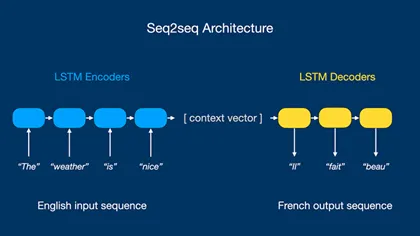

## Seq2Seq with LSTM

In [5]:
class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # self.embedding = nn.Embedding(v_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0)
    
    def forward(self, input_seq):
        # input_seq 2d embbeded into 3d 
        embedded = self.embedding(input_seq)
        # outputs and states
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size    = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim    = hidden_dim
        self.num_layers    = num_layers
        self.embedding     =nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers >1 else 0)
        self.out = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell



In [6]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        # connects encoder and decoder
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, input_seq, target_seq):
        # to ttrain the model
        # input_seq:  english sequence
        # output_seq: french sequence
        batch_size, target_len =target_seq.shape
        device = target_seq.device
        outputs = []
        _enc_out, hidden, cell = self.encoder(input_seq)
        dec_in = target_seq[:, :1]
        for t in range(target_len-1):
            pred, hidden, cell = self.decoder(dec_in, hidden, cell)
            pred = pred[:, -1:, :]
            outputs.append(pred)
            dec_in = torch.cat([dec_in, pred.argmax(dim=2)], dim=1)
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [11]:
class TranslationDataset(Dataset):
    def __init__(self, text_pairs):
        self.text_pairs = text_pairs

    def __len__(self ):
        return len(self.text_pairs)
    def __getitem__(self, idx):
        en, es = self.text_pairs[idx]
        return en, "[start] " + es + " [end]"

def collate_fn(batch):
    en_str, es_str = zip(*batch)
    en_enc = en_tokenizer.encode_batch(en_str, add_special_tokens=True)
    es_enc = es_tokenizer.encode_batch(es_str, add_special_tokens=True)
    en_ids = [enc.ids for enc in en_enc]
    es_ids = [enc.ids for enc in es_enc]

    return torch.tensor(en_ids), torch.tensor(es_ids)

BATCH_SIZE = 16
dataset = TranslationDataset(text_pairs)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, \
                        collate_fn=collate_fn)

In [12]:
for en_ids, es_ids in dataloader:
    print(f"English {en_ids}")
    print(f"Spanish {es_ids}")
    break

English tensor([[ 217,  168, 7554, 7834, 1524,  896,  531, 2862,   14,    2,    2],
        [ 306,  261,  111,   88,  356,  141,   28,    2,    2,    2,    2],
        [  96,  701,  180,  299, 1410,  100,  399, 2518,   14,    2,    2],
        [ 128,  219,  246, 2373,   14,    2,    2,    2,    2,    2,    2],
        [  74, 1458,  569,  191,  995, 1352,   14,    2,    2,    2,    2],
        [ 126,  133,  268,   78,   88,   78, 2148,  160,   78,  118,   14],
        [ 173, 2948,  433, 4068,   14,    2,    2,    2,    2,    2,    2],
        [ 118,   88,  449,  464,   28,    2,    2,    2,    2,    2,    2],
        [ 258,  133,   84, 1902,   14,    2,    2,    2,    2,    2,    2],
        [  88,  234, 2059,  151,  123,   84,  686,   14,    2,    2,    2],
        [ 217,  133,  247,  252,  544,   14,    2,    2,    2,    2,    2],
        [ 118,   88,  192,  457,  269, 1066,   28,    2,    2,    2,    2],
        [  74,  265,   76,  900,  252,  185,   88,  408,  543,   14,    2],
    

In [13]:
en_ids.shape

torch.Size([16, 11])

In [14]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A4000'

In [15]:
import time
from datetime import datetime, timedelta
import gc

In [16]:
def clean():
    torch.cuda.empty_cache()
    gc.collect()

In [17]:
clean()

In [18]:
# create the model
# cpu
#device = torch.device("cpu")

# using cuda
device = torch.device("cuda")
enc_vocab = len(en_tokenizer.get_vocab())
dec_vocab = len(es_tokenizer.get_vocab())

emb_dim    = 256
hidden_dim = 256
num_layers = 1
dropout    = 0.1

encoder = EncoderLSTM(enc_vocab, emb_dim, hidden_dim, num_layers, dropout).to(device)
decoder = DecoderLSTM(dec_vocab, emb_dim, hidden_dim, num_layers, dropout).to(device)

model = Seq2SeqLSTM(encoder, decoder).to(device)
print(model)
import gc
from torch.cuda.amp import autocast, GradScaler

# Reduce batch size in your dataloader first!
# dataloader = DataLoader(..., batch_size=16)  # or 8

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=es_tokenizer.token_to_id("[pad]"))
scaler = GradScaler()

N_EPOCHS = 20
torch.cuda.empty_cache()
print("Training ...")
print(f"Time start: {datetime.now()}\n")

for epoch in range(N_EPOCHS):
    t0 = time.perf_counter()
    model.train()
    epoch_loss = 0
    
    for en_ids, es_ids in dataloader:
        en_ids = en_ids.to(device)
        es_ids = es_ids.to(device)
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(en_ids, es_ids)
            loss = loss_fn(outputs.reshape(-1, dec_vocab), es_ids[:, 1:].reshape(-1))
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        
        # Free memory
        del en_ids, es_ids, outputs, loss
    
    print(f"  Epoch {epoch+1}/{N_EPOCHS} -> Avg Loss {epoch_loss/len(dataloader):.4f}... EpochTime= {time.perf_counter()-t0:.2f}")
    torch.save(model.state_dict(), f"seq2seq-epoch-{epoch+1}.pth")
    
    # Evaluate every 5 epochs (FIXED)
    if (epoch+1) % 5 != 0:
        continue
        
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for en_ids, es_ids in dataloader:
            en_ids = en_ids.to(device)
            es_ids = es_ids.to(device)
            outputs = model(en_ids, es_ids)
            loss = loss_fn(outputs.reshape(-1, dec_vocab), es_ids[:, 1:].reshape(-1))
            eval_loss += loss.item()
            del en_ids, es_ids, outputs, loss
    
    print(f" Eval Loss: {eval_loss/len(dataloader):.4f}")
    
    # Clear cache
    torch.cuda.empty_cache()
    gc.collect()

print(f"\nTime end: {datetime.now()}")

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_fn = nn.CrossEntropyLoss(ignore_index=es_tokenizer.token_to_id("[pad]"))
# N_EPOCHS = 20
# torch.cuda.empty_cache()
# print("Training ...")
# print(f"Time start: {datetime.now()}\n")

# for epoch in range(N_EPOCHS):
#     print(f"Training Epoch {epoch+1}/{N_EPOCHS}")
#     t0 = time.perf_counter()
#     model.train()
#     epoch_loss = 0
#     for en_ids, es_ids in dataloader:
#         en_ids = en_ids.to(device)
#         es_ids = es_ids.to(device)
#         optimizer.zero_grad()
#         outputs = model(en_ids, es_ids)
#         # compute loss
#         loss = loss_fn(outputs.reshape(-1, dec_vocab), es_ids[:, 1:].reshape(-1))
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#         del en_ids, es_ids, outputs, loss
#     torch.cuda.empty_cache()
#     gc.collect()
#     print(f"   -> Avg Loss {epoch_loss/len(dataloader)}, latest Loss {loss.item()}... EpochTime= {time.perf_counter()-t0:.2f}")
#     torch.save(model.state_dict(), f"seq2seq-epoch-{epoch+1}.pth")
#     # --- test every 5 epochs
    
#     if (epoch+1) % 5 != 0:
#         continue
#     model.eval()
#     epoch_loss = 0
#     with torch.no_grad():
#         for en_ids, es_ids in dataloader:
#             en_ids = en_ids.to(device)
#             es_ids = es_ids.to(device)
#             outputs = model(en_ids, es_ids)
#             loss = loss_fn(outputs.reshape(-1, dec_vocab), es_ids[:, 1:].reshape(-1))
#             epoch_loss += loss.item()
#     print(f"    L> Loss: {epoch_loss/len(dataloader)}")

# print(f"\n  Time start: {time.now()}\n")

Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (embedding): Embedding(8000, 256)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): DecoderLSTM(
    (embedding): Embedding(8000, 256)
    (lstm): LSTM(256, 256, batch_first=True)
    (out): Linear(in_features=256, out_features=8000, bias=True)
  )
)


/tmp/ipykernel_2363079/1060380876.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_2363079/1060380876.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Training ...
Time start: 2026-01-16 12:18:22.607577

  Epoch 1/20 -> Avg Loss 4.1441... EpochTime= 486.70
  Epoch 2/20 -> Avg Loss 3.2118... EpochTime= 483.01
  Epoch 3/20 -> Avg Loss 2.8341... EpochTime= 488.03
  Epoch 4/20 -> Avg Loss 2.6152... EpochTime= 489.07
  Epoch 5/20 -> Avg Loss 2.4666... EpochTime= 485.53
 Eval Loss: 2.2532
  Epoch 6/20 -> Avg Loss 2.3535... EpochTime= 484.31
  Epoch 7/20 -> Avg Loss 2.2623... EpochTime= 489.59
  Epoch 8/20 -> Avg Loss 2.1871... EpochTime= 487.68
  Epoch 9/20 -> Avg Loss 2.1204... EpochTime= 492.25
  Epoch 10/20 -> Avg Loss 2.0668... EpochTime= 486.79
 Eval Loss: 1.8878
  Epoch 11/20 -> Avg Loss 2.0187... EpochTime= 493.90
  Epoch 12/20 -> Avg Loss 1.9766... EpochTime= 491.70
  Epoch 13/20 -> Avg Loss 1.9368... EpochTime= 487.70
  Epoch 14/20 -> Avg Loss 1.9034... EpochTime= 496.29
  Epoch 15/20 -> Avg Loss 1.8729... EpochTime= 496.03
 Eval Loss: 1.7039
  Epoch 16/20 -> Avg Loss 1.8469... EpochTime= 493.72
  Epoch 17/20 -> Avg Loss 1.8197...

In [18]:
clean()

In [17]:
del en_ids, es_ids#, outputs, loss
gc.collect()

AttributeError: module 'gc' has no attribute 'collec'

In [19]:
fig = plt.figure()
plt.plot([4.14, 3.21,2.83, 2.61, 2.46, 2.35,2.26,2.18], "-s")

NameError: name 'plt' is not defined

In [30]:
# Test for a few samples
model.eval()
N_SAMPLES = 5
MAX_LEN = 60
with torch.no_grad():
    start_token = torch.tensor([es_tokenizer.token_to_id("[start]")]).to(device)
    
    for k, (en, true_es) in enumerate(random.sample(text_pairs, N_SAMPLES), start=1):
        print(f"Example {k}")
        en_ids = torch.tensor(en_tokenizer.encode(en).ids).unsqueeze(0).to(device)
        _output, hidden, cell = model.encoder(en_ids)
        pred_ids = [start_token]
        for _ in range(MAX_LEN):
            decoder_input = torch.tensor(pred_ids).unsqueeze(0).to(device)
            output, hidden, cell = model.decoder(decoder_input, hidden, cell)
            output = output[:, -1, :].argmax(dim=1)
            pred_ids.append(output.item())
            # early stop if the predicted token is the end token
            if pred_ids[-1] == es_tokenizer.token_to_id("[end]"):
                break
        # Decode the predicted IDs
        pred_es = es_tokenizer.decode(pred_ids)
        print(f"\tEnglish: {en}")
        print(f"\tSpanish: {true_es}")
        print(f"\tPredicted: {pred_es}")
        print()

Example 1
	English: you've only been here for three weeks.
	Spanish: solo llevas tres semanas aquí.
	Predicted:  solo solo semanas de semanas semanas semanas. 

Example 2
	English: he is always late for school.
	Spanish: él siempre llega tarde a la escuela.
	Predicted:  él siempre llega tarde a la escuela. 

Example 3
	English: when i was a boy, i was addicted to reading detective stories.
	Spanish: de niño yo era adicto a la lectura de cuentos policiales.
	Predicted:  cuando él era era adictoaba de de de de de de... 

Example 4
	English: my left foot has gone to sleep.
	Spanish: se me durmió el pie izquierdo.
	Predicted:  mi se se de ido en la.. 

Example 5
	English: i want this.
	Spanish: quiero esto.
	Predicted:  quiero este. 



In [33]:
out_ = '''
Epoch 1/30: Avg Loss4.395070002245286, latest Loss 4.230283737182617
Epoch 2/30: Avg Loss3.6471167070713766, latest Loss 3.752202033996582
Epoch 3/30: Avg Loss3.3167512666988275, latest Loss 4.25619649887085
Epoch 4/30: Avg Loss3.122931292339147, latest Loss 2.6680548191070557
Epoch 5/30: Avg Loss2.996012330255409, latest Loss 3.528635025024414
Epoch 6/30: Avg Loss2.90340663775423, latest Loss 4.059764385223389
Epoch 7/30: Avg Loss2.8327776061905388, latest Loss 2.5466110706329346
Epoch 8/30: Avg Loss2.7730692379367614, latest Loss 2.9503211975097656
Epoch 9/30: Avg Loss2.7255921279925004, latest Loss 2.9581055641174316
Epoch 10/30: Avg Loss2.6840451791987605, latest Loss 2.910048723220825
Epoch 11/30: Avg Loss2.6474239126867025, latest Loss 2.7692813873291016
Epoch 12/30: Avg Loss2.6132248413231824, latest Loss 1.7243056297302246
Epoch 13/30: Avg Loss2.5857321541786833, latest Loss 2.0242347717285156
Epoch 14/30: Avg Loss2.5592526072492583, latest Loss 2.252049207687378
Epoch 15/30: Avg Loss2.5379912600389964, latest Loss 2.193059206008911
Epoch 16/30: Avg Loss2.5140070082205055, latest Loss 3.4826605319976807
Epoch 17/30: Avg Loss2.494886100902731, latest Loss 2.170839548110962
Epoch 18/30: Avg Loss2.4764740065325683, latest Loss 1.9459298849105835
Epoch 19/30: Avg Loss2.4608329166513827, latest Loss 2.8148417472839355
Epoch 20/30: Avg Loss2.4447064101529206, latest Loss 2.6401638984680176
Epoch 21/30: Avg Loss2.4295913077316214, latest Loss 2.381401300430298
Epoch 22/30: Avg Loss2.4152114049666116, latest Loss 3.308819532394409
Epoch 23/30: Avg Loss2.4025127594907087, latest Loss 1.7094573974609375
Epoch 24/30: Avg Loss2.3924225745390073, latest Loss 1.607719898223877
Epoch 25/30: Avg Loss2.3822866682841877, latest Loss 2.1432652473449707
Epoch 26/30: Avg Loss2.3727734302081225, latest Loss 2.054389238357544
Epoch 27/30: Avg Loss2.3604076051750735, latest Loss 2.900049924850464
Epoch 28/30: Avg Loss2.352276003362083, latest Loss 2.0395050048828125
Epoch 29/30: Avg Loss2.3442861011930933, latest Loss 2.983574628829956
Epoch 30/30: Avg Loss2.3366784134417435, latest Loss 1.7407118082046509
'''

In [48]:
outt_ = out_.replace("\n", ' ' ).split(" ")
# print(outt_)
outt_ = outt_[0::7]
# outt_
outt_ = outt_[1:]
# print(outt_)
loss_arr = np.array(list(map(lambda x : float(x), outt_)))


In [50]:
import matplotlib.pyplot as plt

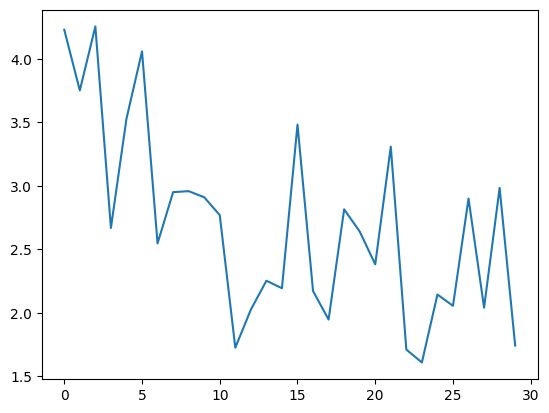

In [51]:
plt.plot(loss_arr)

In [52]:
PATH = "trained_outs/modelo_v1_lowperf.pth"

# Guardar
torch.save(model.state_dict(), PATH)
print(f"lat model saved in {PATH}")

lat model saved in trained_outs/modelo_v1_lowperf.pth


In [13]:
import torch
import gc

def check_gpu_mem():
    if torch.cuda.is_available():
        # Información de hardware
        device = torch.cuda.current_device()
        props = torch.cuda.get_device_properties(device)
        total_mem = props.total_memory / (1024**3) # Convertir a GB
        
        # Información de PyTorch
        allocated = torch.cuda.memory_allocated(device) / (1024**3)
        reserved = torch.cuda.memory_reserved(device) / (1024**3)
        free_approx = total_mem - allocated
        
        print(f"--- 🖥️ GPU: {props.name} ---")
        print(f"Memoria Total:       {total_mem:.2f} GB")
        print(f"Memoria Asignada:    {allocated:.2f} GB (Lo que el modelo usa realmente)")
        print(f"Memoria Reservada:   {reserved:.2f} GB (Caché de PyTorch)")
        print(f"Memoria Libre aprox: {free_approx:.2f} GB")
        
        if allocated > 10:
            print("\n⚠️ ALERTA: Tienes mucha memoria ocupada. Considera reiniciar el kernel.")
    else:
        print("❌ No se detectó ninguna GPU disponible.")

def clean_gpu():
    """Limpia la memoria caché que PyTorch ya no necesita"""
    gc.collect()
    torch.cuda.empty_cache()
    print("🧹 Caché de la GPU limpiada.")

# Ejecutar reporte inicial
check_gpu_mem()

--- 🖥️ GPU: NVIDIA RTX A4000 ---
Memoria Total:       15.62 GB
Memoria Asignada:    13.24 GB (Lo que el modelo usa realmente)
Memoria Reservada:   13.44 GB (Caché de PyTorch)
Memoria Libre aprox: 2.39 GB

⚠️ ALERTA: Tienes mucha memoria ocupada. Considera reiniciar el kernel.


In [14]:
clean_gpu()

🧹 Caché de la GPU limpiada.


In [16]:

check_gpu_mem()

--- 🖥️ GPU: NVIDIA RTX A4000 ---
Memoria Total:       15.62 GB
Memoria Asignada:    13.24 GB (Lo que el modelo usa realmente)
Memoria Reservada:   13.44 GB (Caché de PyTorch)
Memoria Libre aprox: 2.39 GB

⚠️ ALERTA: Tienes mucha memoria ocupada. Considera reiniciar el kernel.
